In [1]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re

In [2]:
# AUTO DATE HANDLING
today = datetime.today()

# If before the 16th, use previous month
if today.day < 16:
    target_date = today - relativedelta(months=1)
else:
    target_date = today

release_month = target_date.month
release_year = target_date.year

release_date = f"{release_month}_{release_year}"
LAKE_CODE = "919"


URL = (
    f"https://www.usbr.gov/uc/water/hydrodata/crmms/current/"
    f"{release_date}/919/json/30.json"
)

EXCEL_PATH = "inflow_24_months_wide.xlsx"
SHEET_NAME = "Data"

print(f"Using release_date = {release_date}")
print(f"Fetching URL = {URL}")

# MAIN BLOCK WITH ERROR HANDLING

try:
    # 1. REQUEST + BUILD RAW DF
    r = requests.get(URL)          # <-assign to r
    r.raise_for_status()
    j = r.json()

    df_raw = pd.DataFrame(j["data"], columns=j["columns"])
    df_raw.insert(0, "timestamp", pd.to_datetime(j["index"], unit="ms"))

    # Keep only desired columns
    cols = ["timestamp", "24MS MOST PROB", "24MS MIN PROB", "24MS MAX PROB"]
    df = df_raw[cols].copy()

    # Sort by timestamp to ensure correct month order
    df = df.sort_values("timestamp").reset_index(drop=True)

    
    df = df.iloc[:24].copy()

    # ASSIGN MONTH NUMBER (1–24)
    df["month"] = df.index + 1   # month_1, month_2, ...

    # Melt to long to pivot into months
    df_long = df.melt(
        id_vars=["month"],
        value_vars=["24MS MOST PROB", "24MS MIN PROB", "24MS MAX PROB"],
        var_name="variable",
        value_name="value"
    )

    # Add release_date
    df_long["release_date"] = release_date

    # PIVOT TO WIDE FORMAT (release_date, variable, month_1..month_24)
    df_wide = df_long.pivot_table(
        index=["release_date", "variable"],
        columns="month",
        values="value"
    )

    # Clean up column names → month_1, month_2, …
    df_wide.columns = [f"month_{m}" for m in df_wide.columns]
    df_wide = df_wide.reset_index()

    print("\nPreview of wide-format (months 1–24):")
    print(df_wide.head().to_string(index=False))

    # APPEND TO HISTORY FILE (WITH ERROR HANDLING)
    if os.path.exists(EXCEL_PATH):
        try:
            df_old = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
            print(f"\nLoaded existing history with {len(df_old)} rows.")
        except PermissionError:
            print(f"Cannot access {EXCEL_PATH}. The file may be open in another program.")
            # Alternative: Save to a different file
            EXCEL_PATH = "inflow_30_months_wide_new.xlsx"
            print(f"Will save to {EXCEL_PATH} instead.")
            df_old = pd.DataFrame(columns=df_wide.columns)
        except Exception as e:
            print(f"Error reading file: {e}")
            df_old = pd.DataFrame(columns=df_wide.columns)
    else:
        df_old = pd.DataFrame(columns=df_wide.columns)

    # Combine old + new
    df_combined = pd.concat([df_old, df_wide], ignore_index=True)

    # Remove duplicates per release_date + variable
    df_combined = df_combined.drop_duplicates(
        subset=["release_date", "variable"],
        keep="last"
    )

    # Save with error handling
    try:
        df_combined.to_excel(EXCEL_PATH, sheet_name=SHEET_NAME, index=False)
        print(f"\nSaved updated monthly wide-format history → {EXCEL_PATH}\n")
    except PermissionError:
        alt_path = f"inflow_30_months_wide_{release_date}.xlsx"
        df_combined.to_excel(alt_path, sheet_name=SHEET_NAME, index=False)
        print(f"\nPermission denied on original file. Saved to → {alt_path}\n")

    # Also save to CSV
    csv_path = "inflow_24_months_wide.csv"
    try:
        df_combined.to_csv(csv_path, index=False)
        print(f"Saved CSV history → {csv_path}")
    except Exception as e:
        print(f"Could not save CSV: {e}")


except Exception as e:
    print(f"An error occurred: {e}")


Using release_date = 2_2026
Fetching URL = https://www.usbr.gov/uc/water/hydrodata/crmms/current/2_2026/919/json/30.json

Preview of wide-format (months 1–24):
release_date       variable    month_1    month_2    month_3    month_4     month_5     month_6    month_7    month_8    month_9   month_10   month_11   month_12   month_13   month_14   month_15   month_16   month_17   month_18    month_19   month_20   month_21   month_22   month_23   month_24
      2_2026  24MS MAX PROB 273611.175 277937.603 392404.772 927320.419 1747813.210 2267162.670 964049.079 642273.784 591751.841 604635.950 512538.064 461076.836 483894.628 481472.554 627442.039 982884.415 2510755.19 2799887.15 1247327.370 611902.913 557428.927 559808.164 517982.962 455649.917
      2_2026  24MS MIN PROB 273611.175 263178.915 319970.371 206462.963  321338.006  372606.823 282231.484 304427.355 312593.614 396089.168 407695.790 350025.847 329886.801 363793.056 496985.956 604623.006 1276180.14 1250086.46  422994.002 376558.388

In [3]:
# AUTO DATE HANDLING

today = datetime.today()

if today.day < 16:
    target_date = today - relativedelta(months=1)
else:
    target_date = today

release_month = target_date.month
release_year = target_date.year
release_date = f"{release_month}_{release_year}"

LAKE_CODE = "919"

URL = (
    f"https://www.usbr.gov/uc/water/hydrodata/crmms/current/"
    f"{release_date}/919/json/30.json"
)

print(f"Using release_date = {release_date}")
print(f"Fetching URL = {URL}")


# MAIN BLOCK WITH ERROR HANDLING
 
try:
    r = requests.get(URL)
    r.raise_for_status()
    j = r.json()

     
    # BUILD RAW DF
     
    df_raw = pd.DataFrame(j["data"], columns=j["columns"])
    df_raw.insert(0, "timestamp", pd.to_datetime(j["index"], unit="ms"))

     
    # NORMALIZE COLUMN NAMES
    # (fixes hidden unicode spaces)
     
    def normalize(col):
        col = re.sub(r"\s+", " ", col, flags=re.UNICODE)  # collapse weird whitespace
        col = re.sub(r"[\u200b\u200c\u200d\uFEFF]", "", col)  # remove zero-width chars
        return col.strip()

    df_raw.columns = [normalize(c) for c in df_raw.columns]

     
    # DESIRED COLUMNS (24MS + ESP)
     
    desired_cols = [
        "timestamp",
        "24MS MOST PROB", "24MS MIN PROB", "24MS MAX PROB",
        "ESP Most", "ESP Min", "ESP Max"
    ]

    # Only keep columns that actually exist
    available_cols = [c for c in desired_cols if c in df_raw.columns]

    missing = set(desired_cols) - set(available_cols)
    if missing:
        print(f"Warning: Missing columns from this release: {missing}")

    df = df_raw[available_cols].copy()

     
    # SORT + TRIM TO 24 MONTHS
     
    df = df.sort_values("timestamp").reset_index(drop=True)
    df = df.iloc[:24].copy()

     
    # ASSIGN MONTH NUMBER
     
    df["month"] = df.index + 1

     
    # MELT TO LONG FORMAT
     
    value_vars = [c for c in available_cols if c != "timestamp"]

    df_long = df.melt(
        id_vars=["month"],
        value_vars=value_vars,
        var_name="variable",
        value_name="value"
    )

    df_long["release_date"] = release_date

     
    # PIVOT TO WIDE FORMAT
     
    df_wide = df_long.pivot_table(
        index=["release_date", "variable"],
        columns="month",
        values="value"
    )

    df_wide.columns = [f"month_{m}" for m in df_wide.columns]
    df_wide = df_wide.reset_index()

    print("\nPreview of wide-format (months 1–24):")
    print(df_wide.head().to_string(index=False))

     
    # SAVE TO A NEW FILE
     
    NEW_FILE = "inflow_24_months_wide_with_esp.xlsx"
    NEW_CSV = "inflow_24_months_wide_with_esp.csv"

    df_wide.to_excel(NEW_FILE, index=False)
    df_wide.to_csv(NEW_CSV, index=False)

    print(f"\nSaved ESP‑included dataset → {NEW_FILE}")
    print(f"Saved ESP‑included CSV → {NEW_CSV}")

except Exception as e:
    print(f"An error occurred: {e}")


Using release_date = 2_2026
Fetching URL = https://www.usbr.gov/uc/water/hydrodata/crmms/current/2_2026/919/json/30.json

Preview of wide-format (months 1–24):
release_date       variable    month_1    month_2    month_3    month_4     month_5     month_6    month_7    month_8    month_9   month_10   month_11   month_12   month_13   month_14   month_15   month_16   month_17   month_18    month_19   month_20   month_21   month_22   month_23   month_24
      2_2026  24MS MAX PROB 273611.175 277937.603 392404.772 927320.419 1747813.210 2267162.670 964049.079 642273.784 591751.841 604635.950 512538.064 461076.836 483894.628 481472.554 627442.039 982884.415 2510755.19 2799887.15 1247327.370 611902.913 557428.927 559808.164 517982.962 455649.917
      2_2026  24MS MIN PROB 273611.175 263178.915 319970.371 206462.963  321338.006  372606.823 282231.484 304427.355 312593.614 396089.168 407695.790 350025.847 329886.801 363793.056 496985.956 604623.006 1276180.14 1250086.46  422994.002 376558.388

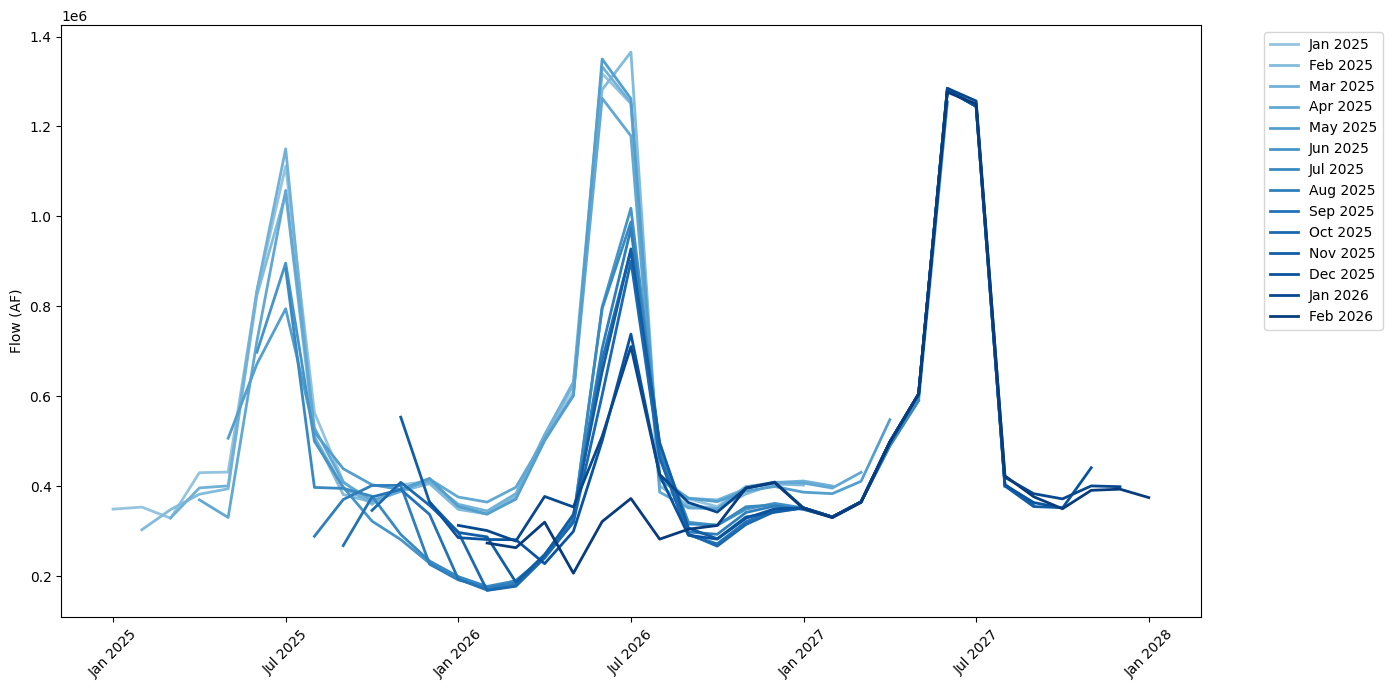

In [4]:
# Load the Excel sheet
df = pd.read_excel('inflow_24_months_wide.xlsx', sheet_name='Data')

# Drop empty columns
df = df.dropna(axis=1, how='all')

# Filter to only 24MS MIN PROB
df_min = df[df['variable'] == '24MS MIN PROB'].copy()

def format_release_label(release_date):
    month, year = release_date.split("_")
    dt = datetime(int(year), int(month), 1)
    return dt.strftime("%b %Y")


# Create a trace name
df_min['Trace'] = df_min['release_date'].apply(format_release_label)
df_min = df_min.set_index('Trace')

# Month columns
months = [f'month_{i}' for i in range(1, 25)]

# Number of traces
n_traces = len(df_min)

# Extended x-axis length
total_months = 24 + (n_traces - 1)

# REAL CALENDAR LABELS STARTING JAN 2025
start_date = datetime(2025, 1, 1)
labels = [
    (start_date + relativedelta(months=i)).strftime("%b %Y")
    for i in range(total_months)
]


# Blue gradient
colors = plt.cm.Blues(np.linspace(0.4, 0.95, n_traces))

plt.figure(figsize=(14, 7))

for i, (trace, color) in enumerate(zip(df_min.index, colors)):
    y = df_min.loc[trace, months].values

    # Stagger by i months
    shifted = np.concatenate([np.full(i, np.nan), y])

    # Pad to full length
    if len(shifted) < total_months:
        shifted = np.concatenate([shifted, np.full(total_months - len(shifted), np.nan)])

    plt.plot(labels, shifted, label=trace, linewidth=2, color=color)

# Show only every 3rd month label
plt.xticks(ticks=range(0, total_months, 6),
           labels=[labels[i] for i in range(0, total_months, 6)],
           rotation=45)

plt.ylabel('Flow (AF)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


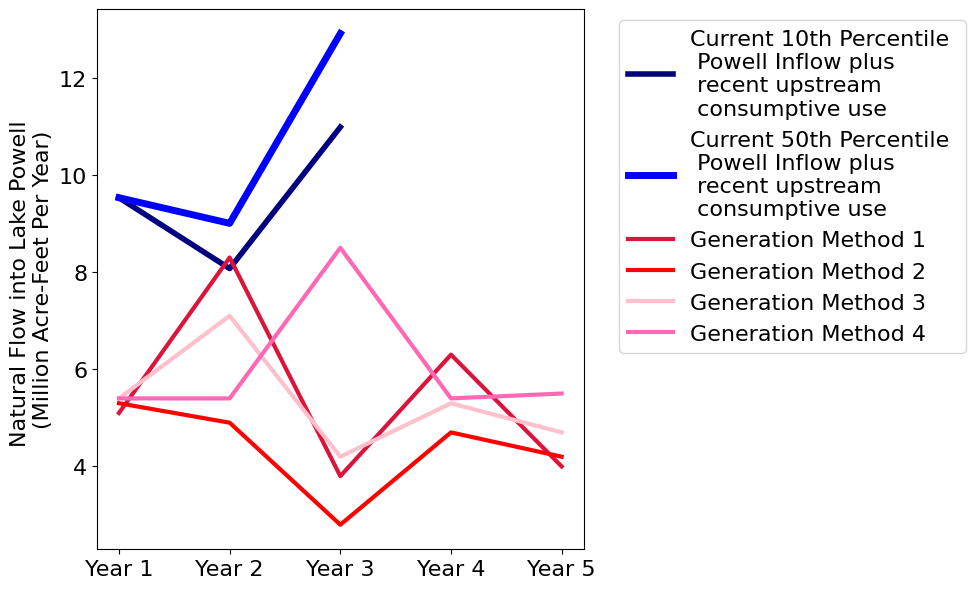

In [60]:
df = pd.read_excel("inflow_24_months_wide_with_esp.xlsx", sheet_name='Sheet1')
df = df.dropna(axis=1, how='all')

months = [f'month_{i}' for i in range(1, 25)]

# This will hold BOTH Min and Most
annual_df = pd.DataFrame()


# ESP MIN

df_min = df[df['variable'] == 'ESP Min'].copy()
df_min['Trace'] = df_min['release_date'] + ' – ' + df_min['variable']
df_min = df_min.set_index('Trace')

for trace in df_min.index:
    monthly_vals = df_min.loc[trace, months].values.astype(float)

    Year_1 = 5.3
    Year_2 = monthly_vals[:12].sum() / 1_000_000
    Year_3 = monthly_vals[12:24].sum() / 1_000_000

    # Add CUL
    Year_1 += 4230820 / 1_000_000
    Year_2 += 4230820 / 1_000_000
    Year_3 += 4230820 / 1_000_000

    annual_df.loc[trace, ['Year_1','Year_2','Year_3','Year_4','Year_5']] = \
        [Year_1, Year_2, Year_3, np.nan, np.nan]


# Rename most recent ESP Min trace

most_recent_min_trace = df_min.index[-1]
most_recent_min_release_date = df_min.loc[most_recent_min_trace, 'release_date']

usbr_min_label = f"Current 10th Percentile \n Powell Inflow plus \n recent upstream \n consumptive use"

annual_df = annual_df.rename(index={most_recent_min_trace: usbr_min_label})



# ESP MOST

df_most = df[df['variable'] == 'ESP Most'].copy()
df_most['Trace'] = df_most['release_date'] + ' – ' + df_most['variable']
df_most = df_most.set_index('Trace')

for trace in df_most.index:
    monthly_vals = df_most.loc[trace, months].values.astype(float)

    Year_1 = 5.3
    Year_2 = monthly_vals[:12].sum() / 1_000_000
    Year_3 = monthly_vals[12:24].sum() / 1_000_000

    # Add CUL
    Year_1 += 4230820 / 1_000_000
    Year_2 += 4230820 / 1_000_000
    Year_3 += 4230820 / 1_000_000

    annual_df.loc[trace, ['Year_1','Year_2','Year_3','Year_4','Year_5']] = \
        [Year_1, Year_2, Year_3, np.nan, np.nan]



# Rename most recent ESP Most trace

most_recent_trace = df_most.index[-1]
most_recent_release_date = df_most.loc[most_recent_trace, 'release_date']

usbr_most_label = f"Current 50th Percentile \n Powell Inflow plus \n recent upstream \n consumptive use"

annual_df = annual_df.rename(index={most_recent_trace: usbr_most_label})




# LOAD SCENARIOS FROM 5-YEAR RESULTS


hydro = pd.read_excel('5yearsMinimumSumHydrologyResults.xlsx')
hydro.columns = hydro.columns.str.strip()

# Clean Ensemble
hydro['Ensemble'] = hydro['Ensemble'].astype(str).str.strip()

# Convert Trace column from 'trace17' → 17
hydro['Trace'] = (
    hydro['Trace']
    .astype(str)
    .str.strip()
    .str.replace('trace', '', case=False)
    .astype(int)
)


# Scenario 1: CMIP5_BCSD, Trace 65


scenario1 = hydro[(hydro['Ensemble'] == 'CMIP5_BCSD') & (hydro['Trace'] == 65)].copy()
scenario1 = scenario1[['Year1', 'Year2', 'Year3','Year4','Year5']]
scenario1.index = ['Generation Method 1']
scenario1 = scenario1.rename(columns={
    'Year1': 'Year_1',
    'Year2': 'Year_2',
    'Year3': 'Year_3',
    'Year4': 'Year_4',
    'Year5': 'Year_5',
})


# Scenario 2: RCP_85_100, Trace 17


scenario2 = hydro[(hydro['Ensemble'] == 'RCP85_100') & (hydro['Trace'] == 17)].copy()
scenario2 = scenario2[['Year1', 'Year2', 'Year3','Year4','Year5']]
scenario2.index = ['Generation Method 2']
scenario2 = scenario2.rename(columns={
    'Year1': 'Year_1',
    'Year2': 'Year_2',
    'Year3': 'Year_3',
    'Year4': 'Year_4',
    'Year5': 'Year_5',
})

# Scenario 3: CMIP5_LOCA, Trace 50


scenario3 = hydro[(hydro['Ensemble'] == 'CMIP5_LOCA') & (hydro['Trace'] == 50)].copy()
scenario3 = scenario3[['Year1', 'Year2', 'Year3','Year4','Year5']]
scenario3.index = ['Generation Method 3']
scenario3 = scenario3.rename(columns={
    'Year1': 'Year_1',
    'Year2': 'Year_2',
    'Year3': 'Year_3',
    'Year4': 'Year_4',
    'Year5': 'Year_5',
})


# Scenario 4: CMIP3, Trace 55


scenario4 = hydro[(hydro['Ensemble'] == 'CMIP3') & (hydro['Trace'] == 55)].copy()
scenario4 = scenario4[['Year1', 'Year2', 'Year3','Year4','Year5']]
scenario4.index = ['Generation Method 4']
scenario4 = scenario4.rename(columns={
    'Year1': 'Year_1',
    'Year2': 'Year_2',
    'Year3': 'Year_3',
    'Year4': 'Year_4',
    'Year5': 'Year_5',
})

# MERGE USBR + BOTH SCENARIOS


combined = pd.concat([annual_df, scenario1, scenario2, scenario3, scenario4], axis=0)



# PLOT



years = ['Year_1', 'Year_2', 'Year_3', 'Year_4', 'Year_5']
year_labels = ['Year 1', 'Year 2', 'Year 3','Year 4','Year 5']

custom_styles = {
    # ESP Min 
    usbr_min_label: {'color': 'navy', 'linewidth': 4},


    # ESP Most
    usbr_most_label: {'color': 'Blue', 'linewidth': 5},

    # Scenarios
    'Generation Method 1': {'color': 'crimson', 'linestyle': '-', 'linewidth': 3},
    'Generation Method 2': {'color': 'red', 'linestyle': '-', 'linewidth': 3},
    'Generation Method 3': {'color': 'pink', 'linestyle': '-', 'linewidth': 3},
    'Generation Method 4': {'color': 'hotpink', 'linestyle': '-', 'linewidth': 3},
}

plt.figure(figsize=(10, 6))

# Constant line at 7.48 MAF
#plt.axhline(y=7.48, color='lightblue', linestyle='--', linewidth=2, label='Glen Canyon Dam Release')

for trace, style in custom_styles.items():
    if trace in combined.index:
        plt.plot(year_labels, combined.loc[trace, years], label=trace, **style)

plt.ylabel('Natural Flow into Lake Powell \n(Million Acre-Feet Per Year)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()


In [45]:
# Load and clean
hydro = pd.read_excel('5yearsMinimumSumHydrologyResults.xlsx')
hydro.columns = hydro.columns.str.strip()

hydro['Ensemble'] = hydro['Ensemble'].astype(str).str.strip()
hydro['Sum'] = pd.to_numeric(hydro['Sum'], errors='coerce')

# Compute 5-year average
hydro['Average_5yr'] = hydro['Sum'] / 5

# Filter for traces with 5-year average < 6.5 MAF
low_flow = hydro[hydro['Average_5yr'] < 7.5]

# Count traces per ensemble
traces_per_ensemble = low_flow.groupby('Ensemble')['Trace'].nunique()

print("Number of traces with 5-year average < 7.5 MAF per ensemble:")
print(traces_per_ensemble)


Number of traces with 5-year average < 7.5 MAF per ensemble:
Ensemble
AR1                2
CMIP3             10
CMIP5_BCSD         4
CMIP5_LOCA        11
Drought_Paleo     10
NPC_1988_2020      1
NPC_2000_2020      2
RCP45_100         47
RCP85_065         91
RCP85_100        112
Name: Trace, dtype: int64
